In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
from scipy.signal import welch
from scipy.integrate import simps
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#Algorithm for computing bandpower from EEG data
def bandpower(data, sf, window_sec=None, relative=False):
    # Frequency bands definition
    eeg_bands = {'Delta': (1, 4),
                 'Theta': (4, 8),
                 'Alpha': (8, 12),
                 'Beta': (12, 30),
                 'Gamma': (30, 120)}

    bp_array = []
    for band in ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']:
        low, high = eeg_bands[band]
        # Defining window length
        if window_sec is not None:
            nseg = window_sec * sf
        else:
            nseg = (2 / low) * sf
        if nseg > sf:
            nseg = sf
        # Computing the  modified periodogram (Welch)
        freqs, psd = welch(data, sf, nperseg=nseg)
        # Frequency resolution
        freq_res = freqs[1] - freqs[0]
        # Finding the  closest indices of band in frequency vector
        idx_band = np.logical_and(freqs >= low, freqs <= high)
        bp = simps(psd[idx_band], dx=freq_res)
        if relative:
            bp /= simps(psd, dx=freq_res)
        bp_array.append(bp)
    return np.array(bp_array)




In [2]:
# Loading the data
data = sio.loadmat('WLDataCW.mat')
x_data = data['data']
y_data = data['label'].reshape(-1)

In [3]:

# Calculate Bandpower Features from EEG Data
bandpower_features = np.empty([0, 310])
for sample in range(x_data.shape[-1]):
    eeg_features = []
    for electrode in range(x_data.shape[0]):
        eeg_features.append(bandpower(x_data[electrode, :, sample], 256, None, True))
    arr = np.array(eeg_features).reshape(1, -1)
    bandpower_features = np.append(bandpower_features, arr, axis=0)

In [4]:

# Perform data preprocessing and split the data into training and testing sets for model training and evaluation.
x_train, x_test, y_train, y_test = train_test_split(bandpower_features, y_data, test_size=0.2, random_state=42)

Fold 1
********** Confusion Matrix **********
[[14 21]
 [ 7 16]]


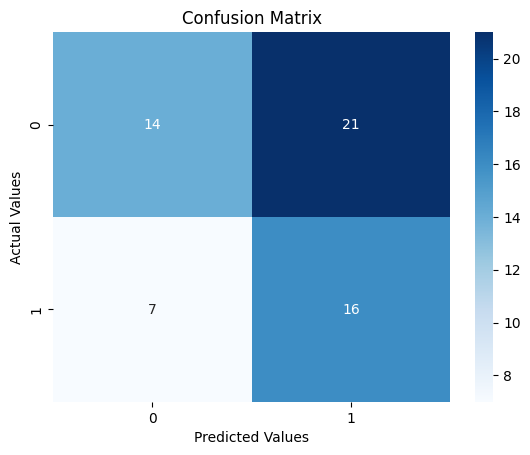

********** Classification Report **********
              precision    recall  f1-score   support

           0       0.67      0.40      0.50        35
           1       0.43      0.70      0.53        23

    accuracy                           0.52        58
   macro avg       0.55      0.55      0.52        58
weighted avg       0.57      0.52      0.51        58

Fold 2
********** Confusion Matrix **********
[[16 11]
 [13 18]]


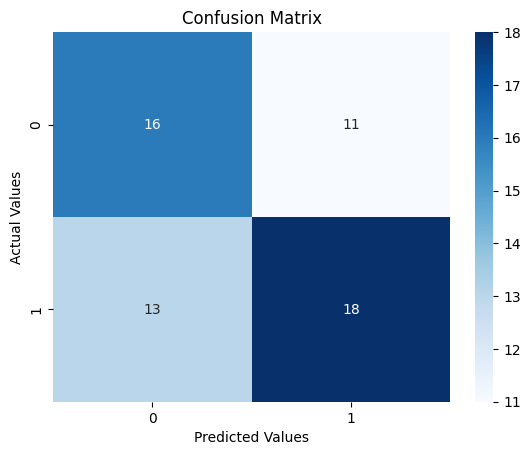

********** Classification Report **********
              precision    recall  f1-score   support

           0       0.55      0.59      0.57        27
           1       0.62      0.58      0.60        31

    accuracy                           0.59        58
   macro avg       0.59      0.59      0.59        58
weighted avg       0.59      0.59      0.59        58

Fold 3
********** Confusion Matrix **********
[[14 16]
 [12 16]]


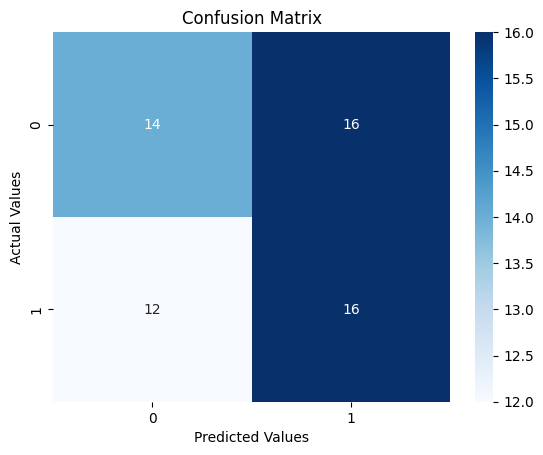

********** Classification Report **********
              precision    recall  f1-score   support

           0       0.54      0.47      0.50        30
           1       0.50      0.57      0.53        28

    accuracy                           0.52        58
   macro avg       0.52      0.52      0.52        58
weighted avg       0.52      0.52      0.52        58

Fold 4
********** Confusion Matrix **********
[[16 11]
 [15 15]]


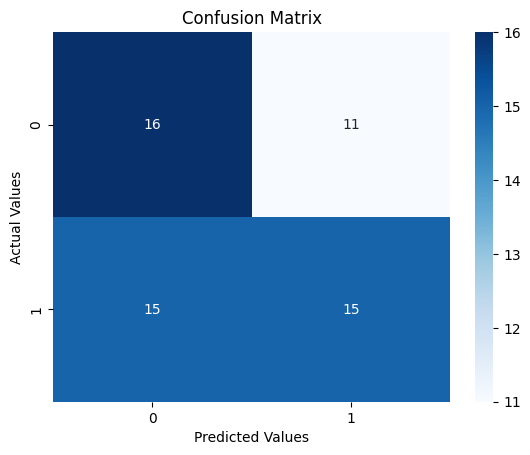

********** Classification Report **********
              precision    recall  f1-score   support

           0       0.52      0.59      0.55        27
           1       0.58      0.50      0.54        30

    accuracy                           0.54        57
   macro avg       0.55      0.55      0.54        57
weighted avg       0.55      0.54      0.54        57

Fold 5
********** Confusion Matrix **********
[[19  5]
 [25  8]]


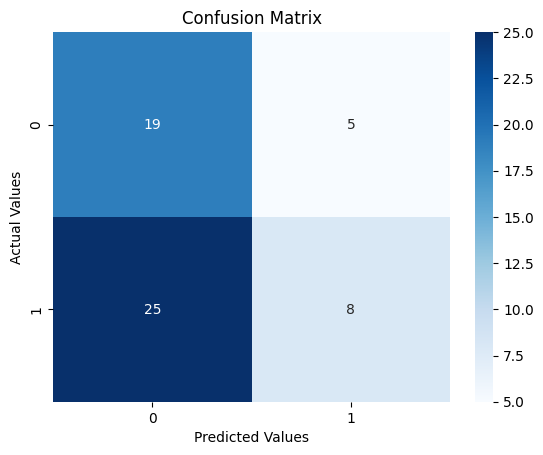

********** Classification Report **********
              precision    recall  f1-score   support

           0       0.43      0.79      0.56        24
           1       0.62      0.24      0.35        33

    accuracy                           0.47        57
   macro avg       0.52      0.52      0.45        57
weighted avg       0.54      0.47      0.44        57

Cross-validation accuracy: 0.5276467029643073


In [5]:
# Neural Network class for binary classification
class NeuralNetwork:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        #  Initializing  weights and biases with random values
        self.W = np.random.normal(loc=0.0, scale=1e-2, size=(X.shape[0], y.shape[0]))
        self.b = np.random.normal(loc=0.0, scale=1e-2, size=(y.shape[0], 1))
        self.loss_lst = []

    # Using Sigmoid Activation Function
    def sigmoid_activation(self, Z):
        return 1 / (1 + np.exp(-Z))
    # Log loss function
    def log_loss(self, y_hat):
        return self.y * np.log(y_hat) + (1 - self.y) * np.log(1 - y_hat)

    # Performing Forward Propagation
    def forward_propagation(self):
        y_hat = self.sigmoid_activation(np.matmul(self.W.transpose(), self.X) + self.b)
        loss = -1 * (self.log_loss(y_hat)).sum() / self.X.shape[1]
        return y_hat, loss


    # Training the neural network
    def fit(self, learning_rate, n_epochs=3000, plot=True):
        for i in range(n_epochs):
            y_hat, loss = self.forward_propagation()
            wderv = self.X @ np.transpose(y_hat - self.y) / self.X.shape[1]
            bderv = np.sum(y_hat - self.y) / self.X.shape[1]
            self.W = self.W - learning_rate * wderv
            self.b = self.b - learning_rate * bderv
            self.loss_lst.append(loss)
            if loss <= 0.0001:
                break
        if plot:
            self.plot_loss()
        return self.W, self.b
    # Plot loss curve
    def plot_loss(self):
        plt.plot(self.loss_lst)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.show()
    # Model Prediction function
    def predict(self, X_test):
        return np.where(self.sigmoid_activation(np.matmul(self.W.transpose(), X_test) + self.b).reshape(-1) > 0.5, 1, 0)

    # Plotting confusion Matrix
    def plot_confusion_matrix(self, cm):
        ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
        ax.set_xlabel('Predicted Values')
        ax.set_ylabel('Actual Values')
        ax.set_title('Confusion Matrix')
        plt.show()

    #  Report accuracy
    def accuracy_report(self, X_test, y_test):
        pred = self.predict(X_test)
        print('*' * 10 + ' Confusion Matrix ' + '*' * 10)
        cm = confusion_matrix(y_test, pred)
        print(cm)
        self.plot_confusion_matrix(cm)
        print('*' * 10 + ' Classification Report ' + '*' * 10)
        print(classification_report(y_test, pred))
        return np.mean(pred == y_test)




# Performing 5-fold cross-validation
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True)
cross_val_acc = 0

for fold, (train_idx, test_idx) in enumerate(kf.split(y_train)):
    print('Fold {}'.format(fold + 1))
    X_fold_train, X_fold_val = x_train[:, train_idx], x_train[:, test_idx]
    y_fold_train, y_fold_val = y_train[train_idx], y_train[test_idx]

    nn = NeuralNetwork(X_fold_train, y_fold_train.reshape(1, -1))
    nn.fit(0.01, plot=False)
    acc_fold = nn.accuracy_report(X_fold_val, y_fold_val)
    cross_val_acc += acc_fold

print('Cross-validation accuracy:', cross_val_acc / n_folds)

